In [1]:
import json
import os
import torch
from torch import nn
import dltools

In [2]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,num_heads, num_layers, dropout, max_len, devices):
    data_dir = "E:/data/bert.small.torch/"
    # 定义空词表以加载预定义词表
    vocab = dltools.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir,'vocab.json')))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(vocab.idx_to_token)}
    bert = dltools.BERTModel(len(vocab), num_hiddens, norm_shape=[256],
                         ffn_num_input=256, ffn_num_hiddens=ffn_num_hiddens,
                         num_heads=4, num_layers=2, dropout=0.2,
                         max_len=max_len, key_size=256, query_size=256,
                         value_size=256, hid_in_features=256,
                         mlm_in_features=256, nsp_in_features=256)
    # 加载预训练BERT参数
    bert.load_state_dict(torch.load(os.path.join(data_dir,'pretrained.params')))
    return bert, vocab

In [3]:
devices = dltools.try_all_gpus()
bert, vocab = load_pretrained_model('bert.small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,num_layers=2, dropout=0.1, max_len=512, devices=devices)

In [4]:
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [
            [p_tokens, h_tokens] for p_tokens, h_tokens in 
            zip(*[dltools.tokenize([s.lower() for s in sentences])for sentences in dataset[:2]])
        ]

        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        out = [self._mp_worker(x) for x in all_premise_hypothesis_tokens]
        all_token_ids = [token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments, dtype=torch.long),
                torch.tensor(valid_lens))

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = dltools.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # 为BERT输入中的'<CLS>'、'<SEP>'和'<SEP>'词元保留位置
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

In [5]:
# 如果出现显存不足错误，请减少“batch_size”。在原始的BERT模型中，max_len=512
batch_size, max_len, num_workers = 256, 128, dltools.get_dataloader_workers()
data_dir = "E:/data/snli_1.0/"
train_set = SNLIBERTDataset(dltools.read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(dltools.read_snli(data_dir, False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size,num_workers=num_workers)

read 549367 examples
read 9824 examples


In [6]:
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.Linear(256, 3)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :])) #去除中间的维度

In [7]:
net = BERTClassifier(bert)

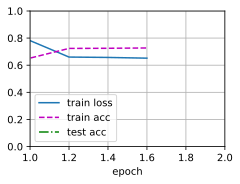

In [ ]:
lr, num_epochs = 1e-4, 2
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
dltools.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,devices)